In [1]:
import scanpy as sc
import anndata
import numpy as np

In [2]:
dataset = 'Immune_Human'
dir_path = "/home/ajita/Documents/data_integration/Immune/"
emb_dir =  "/home/ajita/Documents/data_integration/step1/"

batch_key_dic = {'Immune_Human' : 'batch',
                 'Lung' : 'batch',
                 'Pancreas' : 'tech',
                 'Human_Mouse' : 'batch',
                 'Human_Retina': "Batch",
                 
                }

cell_type_key_dic = {'Immune_Human' : 'final_annotation',
                 'Lung' : 'cell_type',
                 'Pancreas' : 'celltype',
                 'Human_Mouse' : "celltype",
                 "Human_Retina":"Subcluster",
                    }    

#got these results from GMM
req_clus_dic = {"Lung" : 17,
                "Pancreas": 14,
                "Immune_Human": 14, # 16>> 15 >> 14 >> 13 >> 14 (wrong merging happening)
                "Human_Retina" : 13
                       }

def load_data(dataset,batch_key):
    adata =sc.read_h5ad(dir_path+dataset+'.h5ad')
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata
    sc.pp.highly_variable_genes(
            adata,
            flavor = "seurat",
            n_top_genes = 2000,
            layer = "counts",
            batch_key = batch_key,
            subset = True
    )
    return adata

In [3]:
cell_type = cell_type_key_dic[dataset]
batch = batch_key_dic[dataset]
req_clusters = req_clus_dic[dataset]

In [4]:
import pandas as pd
adata = sc.read_h5ad(dir_path + dataset + '.h5ad')
emb = pd.read_csv(emb_dir + dataset + "_latent_matrix_c99_step1.csv",header = None)
adata.obsm['X_emb'] = emb.values
no_of_cell_types = len(adata.obs[cell_type].unique())
emb = sc.AnnData(emb)
sc.pp.neighbors(emb,use_rep = 'X',random_state = 0)

/tmp/ipykernel_1895560/2516171306.py:6: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  emb = sc.AnnData(emb)
/home/ajita/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
2023-04-17 10:32:53.449878: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-17 10:32:53.449912: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
def find_resolution(adata_org, n_clusters):
    
    adata = adata_org.copy()
    obtained_clusters = -1
    iteration = 0
    resolutions = [0., 1000.]
    
    while obtained_clusters != n_clusters and iteration < 50:
        
        current_res = sum(resolutions)/2
        sc.tl.louvain(adata, resolution = current_res, random_state = 0)
        
        labels = adata.obs['louvain']
        obtained_clusters = len(np.unique(labels))
        
        if obtained_clusters < n_clusters:
            resolutions[0] = current_res
        else:
            resolutions[1] = current_res
            
        iteration = iteration + 1
        
    print("find resolution iterations = {}, obtained_clusters = {}".format(iteration,obtained_clusters))
    return current_res

In [6]:

opt_res = find_resolution(emb, req_clusters) # no_of_cell_types
sc.tl.louvain(emb, resolution = opt_res, key_added = 'pseudo_cell_types')



find resolution iterations = 15, obtained_clusters = 14


In [7]:
"""
##############################
Computing Cluster Connectivity
##############################
"""

def compute_undirected_cluster_connectivity(
    communities, adj, z_threshold=1.0, conn_threshold=None
):
    N = communities.shape[0]
    n_communities = np.unique(communities).shape[0]

    # Create cluster index
    clusters = {}
    for idx in np.unique(communities):
        cluster_idx = communities == idx
        clusters[idx] = cluster_idx

    undirected_cluster_connectivity = pd.DataFrame(
        np.zeros((n_communities, n_communities)),
        index=np.unique(communities),
        columns=np.unique(communities),
    )
    undirected_z_score = pd.DataFrame(
        np.zeros((n_communities, n_communities)),
        index=np.unique(communities),
        columns=np.unique(communities),
    )
    cluster_outgoing_edges = {}
    for i in np.unique(communities):
        cluster_i = clusters[i]

        # Compute the outgoing edges from the ith cluster
        adj_i = adj[cluster_i, :]
        adj_ii = adj_i[:, cluster_i]
        e_i = np.sum(adj_i) - np.sum(adj_ii)
        n_i = np.sum(cluster_i)
        cluster_outgoing_edges[i] = e_i

        for j in np.unique(communities):
            if i == j:
                continue
            # Compute the outgoing edges from the jth cluster
            cluster_j = clusters[j]
            adj_j = adj[cluster_j, :]
            adj_jj = adj_j[:, cluster_j]
            e_j = np.sum(adj_j) - np.sum(adj_jj)
            n_j = np.sum(cluster_j)

            # Compute the number of inter-edges from the ith to jth cluster
            adj_ij = adj_i[:, cluster_j]
            e_ij = np.sum(adj_ij)

            # Compute the number of inter-edges from the jth to ith cluster
            adj_ji = adj_j[:, cluster_i]
            e_ji = np.sum(adj_ji)
            e_sym = e_ij + e_ji

            # Compute the random assignment of edges from the ith to the jth
            # cluster under the PAGA binomial model
            e_sym_random = (e_i * n_j + e_j * n_i) / (N - 1)

            # Compute the cluster connectivity measure
            std_sym = (e_i * n_j * (N - n_j - 1) + e_j * n_i * (N - n_i - 1)) / (
                N - 1
            ) ** 2
            undirected_z_score.loc[i, j] = (e_sym - e_sym_random) / std_sym

            # Only add non-spurious edges based on a threshold
            undirected_cluster_connectivity.loc[i, j] = (e_sym - e_sym_random) / (
                e_i + e_j - e_sym_random
            )
            if conn_threshold is not None:
                if undirected_cluster_connectivity.loc[i, j] < conn_threshold:
                    undirected_cluster_connectivity.loc[i, j] = 0
            elif undirected_z_score.loc[i, j] < z_threshold:
                undirected_cluster_connectivity.loc[i, j] = 0
    return undirected_cluster_connectivity, undirected_z_score

# ....Computing connectivity....
from sklearn.neighbors import kneighbors_graph
A = kneighbors_graph(emb.X, 2, mode='connectivity', include_self=True)
A = A.toarray()

clus_conn, undirected_z_score = compute_undirected_cluster_connectivity(emb.obs['pseudo_cell_types'], A)



In [8]:
clus_conn

,0,1,10,11,12,13,2,3,4,5,6,7,8,9
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.437146,0.000000,0.000000,0.56223,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.509932,0.000000,0.110299,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.292808,0.144984
10,0.000000,0.509932,0.000000,0.000000,0.104444,0.018711,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
11,0.000000,0.000000,0.000000,0.000000,0.053031,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.129133,0.000000
12,0.000000,0.110299,0.104444,0.053031,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.038568,0.085731
13,0.000000,0.000000,0.018711,0.000000,0.000000,0.000000,0.000000,0.469914,0.000000,0.00000,0.000000,0.060480,0.000000,0.000000
2,0.437146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.236859,0.00000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.469914,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.236859,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.059938
5,0.562230,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [9]:
clus_conn.max(1)

0     0.562230
1     0.509932
10    0.509932
11    0.129133
12    0.110299
13    0.469914
2     0.437146
3     0.469914
4     0.236859
5     0.562230
6     0.483553
7     0.483553
8     0.292808
9     0.296641
dtype: float64

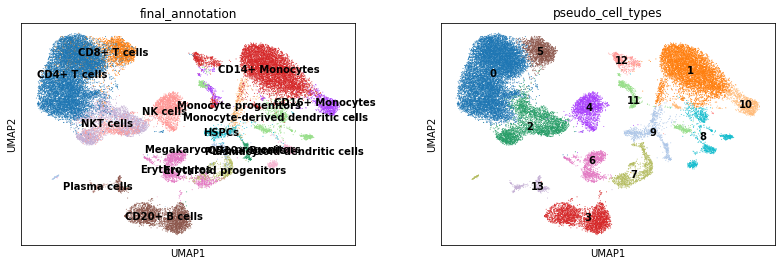

In [10]:
adata.obs['pseudo_cell_types'] = emb.obs['pseudo_cell_types'].values.copy()
sc.pp.neighbors(adata, use_rep='X_emb')
sc.tl.umap(adata)
sc.pl.umap(adata,color=[cell_type, "pseudo_cell_types"], legend_loc='on data') #psuedo_gmm_labels, celltype_NA

In [11]:
a = clus_conn.max(1)
conn_clusters = a[a >= 0.5].index

print (conn_clusters)

Index(['0', '1', '10', '5'], dtype='object')


In [12]:
"""
############## 
Farthest point logic 
###############
"""

from annoy import AnnoyIndex

def farthest_point(clusters, from_points):
    
    distances = np.zeros(clusters.shape[0])
    for point_ind,point in enumerate(clusters):
        
        dist = from_points.copy()
        dist = ((dist-point)**2).sum()
        distances[point_ind] = dist
        
    far_ind = distances.argmax()
    far_point = clusters[far_ind]
    
    return far_point


def nn_annoy(mean, emb, no_of_nn):
    
    tree = AnnoyIndex(emb.shape[1], metric="angular") #euclidean
    tree.set_seed(0)
    
    for i in range(emb.shape[0]):
        tree.add_item(i, emb[i, :])
        
    tree.build(50)
    
    #search_k = -1 means extract search neighbors
    ind = tree.get_nns_by_vector(mean, no_of_nn, search_k=-1)
    return ind

def update_sudo_lables(adata,label_percent):
    
    adata.obs['celltype_NA'] = adata.obs['pseudo_cell_types'].cat.add_categories(['NA'])
    from_points = np.zeros((len(adata.obs['pseudo_cell_types'].unique()),adata.X.shape[1]))
    from_points_ind = 0
    
    # compute from_points data struture for farthest point assignment...
    for label in adata.obs['pseudo_cell_types'].unique():
        
        if label == 'NA':
            continue
        
        if label in conn_clusters:

            is_label = adata.obs['pseudo_cell_types'] == label
            names = adata.obs['pseudo_cell_types'][is_label].index
            data = adata[is_label].X 
            mean = data.mean(axis = 0)
            from_points[from_points_ind] = mean
            from_points_ind += 1 
    
    
    for label in adata.obs['pseudo_cell_types'].unique():
        
        if label == 'NA':
            continue
        
        if label in conn_clusters:
            #print ('hi')
            is_label = adata.obs['pseudo_cell_types'] == label
            no_of_nn = int(sum(is_label)*label_percent) #no of nearest neighbours

            names = adata.obs['pseudo_cell_types'][is_label].index
            data = adata[is_label].X 
            # mean = data.mean(axis = 0)

            mean = farthest_point(data, from_points)
            ind = nn_annoy(mean,data,no_of_nn)

            adata.obs['celltype_NA'][names] = 'NA'
            adata.obs['celltype_NA'][names[ind]] = label   
            
                                 

In [13]:
emb.obs['pseudo_cell_types'] = adata.obs['pseudo_cell_types'].values.copy()

In [14]:
update_sudo_lables(emb, label_percent = 0.1)


In [15]:
print (emb.obs['celltype_NA'].value_counts())

NA    18281
2      3203
3      2679
4      1705
0      1175
6      1103
7      1049
8      1008
9       923
11      697
1       606
12      482
13      347
5       157
10       91
Name: celltype_NA, dtype: int64


In [16]:
"""
Randomly choose 50% points from centroid method for non-connected clusters
"""

from annoy import AnnoyIndex
def nn_annoy(mean, emb, no_of_nn):
    tree = AnnoyIndex(emb.shape[1], metric="angular") #euclidean
    tree.set_seed(0)
    for i in range(emb.shape[0]):
        tree.add_item(i, emb[i, :])
    tree.build(50)#n_trees=50
    ind = tree.get_nns_by_vector(mean, no_of_nn, search_k=-1) #search_k = -1 means extract search neighbors
    # ind = np.array(ind)
    return ind

def update_sudo_labels_mean(adata, na_percent):
    
    adata.obs['pseudo_cell_types'] = adata.obs['pseudo_cell_types'].cat.add_categories(['NA'])
    
    for label in adata.obs['pseudo_cell_types'].unique():
        
        if label not in conn_clusters:
            is_label = adata.obs['pseudo_cell_types'] == label
            #na_percent = 0.5

            no_of_nn = sum(is_label)-int(sum(is_label)*na_percent)
            names = adata.obs['pseudo_cell_types'][is_label].index

            data = adata[is_label].X 
            mean = data.mean(axis=0)

            ind = nn_annoy(mean,data,no_of_nn)

            adata.obs['celltype_NA'][names] = 'NA'
            adata.obs['celltype_NA'][names[ind]] = label
"""
import random

def update_sudo_labels_mean(adata, na_percent):
    
    for label in adata.obs['pseudo_cell_types'].unique():        
        if label not in conn_clusters:
            
            is_label = adata.obs['pseudo_cell_types'] == label

            names = adata.obs['pseudo_cell_types'][is_label].index
            
            #print (names.tolist())
            indices = np.random.choice(names, size = int(na_percent*len(names)))
            #indices = random.sample(names.tolist(), na_percent*len(names))
            adata.obs['celltype_NA'][indices] = 'NA'
"""

"\nimport random\n\ndef update_sudo_labels_mean(adata, na_percent):\n    \n    for label in adata.obs['pseudo_cell_types'].unique():        \n        if label not in conn_clusters:\n            \n            is_label = adata.obs['pseudo_cell_types'] == label\n\n            names = adata.obs['pseudo_cell_types'][is_label].index\n            \n            #print (names.tolist())\n            indices = np.random.choice(names, size = int(na_percent*len(names)))\n            #indices = random.sample(names.tolist(), na_percent*len(names))\n            adata.obs['celltype_NA'][indices] = 'NA'\n"

In [17]:
#update_sudo_lables_mean(emb)
update_sudo_labels_mean(emb, 0.5)

print (emb.obs['celltype_NA'].value_counts())

NA    24875
2      1602
3      1340
0      1175
4       853
1       606
6       552
7       525
8       504
9       462
11      349
12      241
13      174
5       157
10       91
Name: celltype_NA, dtype: int64


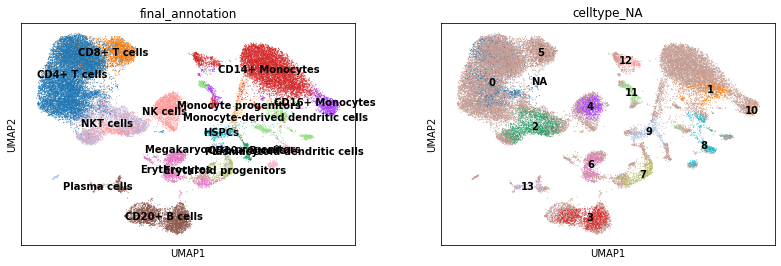

In [18]:
col_name = "celltype_NA"
adata.obs[col_name] = emb.obs[col_name].values.copy()

sc.pp.neighbors(adata, use_rep='X_emb')
sc.tl.umap(adata)
sc.pl.umap(adata,color=[cell_type, col_name],legend_loc = 'on data') #psuedo_gmm_labels, celltype_NA


In [19]:

adata_ori = sc.read_h5ad(dir_path + dataset + '.h5ad')
adata_ori.obs['celltype_NA'] = emb.obs[col_name].values.copy()
#adata_ori.obs['cell_type_inferred'] = emb.obs[col_name].values.copy()
#adata_ori.obs['cell_type_inferred'].loc[adata_ori.obs['cell_type_inferred'] == 'NA'] = '0'
adata_ori.obs['cell_type_inferred'] = adata.obs['pseudo_cell_types'].values.copy()
"""
dt = pd.DataFrame({"ground truth" : adata_ori.obs["cell_type"], 
                   "pseudo inferred labels" : adata_ori.obs["celltype_NA"],
                   "labels used in impl." : adata_ori.obs["cell_type_inferred"]
                  })
dt['count'] = 1
dt.to_excel(dir_path + "cluster_analysis_lung_gmm_0.99.xlsx")
"""
adata_ori.write(dir_path + dataset + '_pseudo_cell_types_apr17_10per.h5ad')


In [20]:
purity = pd.DataFrame(columns = sorted(adata.obs["celltype_NA"].unique()))

for cluster in  adata.obs[cell_type].unique(): #['5','6','8']:
    
    temp = pd.DataFrame(adata.obs["celltype_NA"][adata.obs[cell_type]== cluster].value_counts()).T
    temp.index = [cluster]
    purity = pd.concat([purity,temp], axis = 0)

In [21]:
purity.sort_index()

,0,1,10,11,12,13,2,3,4,5,6,7,8,9,NA
CD10+ B cells,0,0,0,0,0,0,0,0,0,0,0,0,0,24,183
CD14+ Monocytes,0,543,0,53,236,0,0,0,0,0,0,0,6,0,5645
CD16+ Monocytes,0,25,91,128,3,0,0,0,0,0,0,0,0,0,750
CD20+ B cells,0,0,0,0,0,84,0,1340,0,0,0,0,2,2,1445
CD4+ T cells,1104,0,0,0,0,0,16,0,0,21,0,0,0,0,9870
CD8+ T cells,53,0,0,0,0,0,0,0,0,136,0,0,0,0,1994
Erythrocytes,2,1,0,0,0,0,0,0,0,0,552,176,0,0,771
Erythroid progenitors,1,1,0,0,0,0,0,0,0,0,0,326,0,0,135
HSPCs,0,1,0,0,0,0,0,0,0,0,0,0,14,309,149
Megakaryocyte progenitors,7,0,0,0,0,0,0,0,0,0,0,23,0,30,210


In [22]:
"""
##############################
Computing Cluster Connectivity
##############################
"""

'\n##############################\nComputing Cluster Connectivity\n##############################\n'

In [23]:
adata

AnnData object with n_obs × n_vars = 33506 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'pseudo_cell_types', 'celltype_NA'
    var: 'gene_id-0', 'n_cells-0', 'gene_ids-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'gene_id-3', 'n_cells-3', 'n_cells-4'
    uns: 'neighbors', 'umap', 'final_annotation_colors', 'pseudo_cell_types_colors', 'celltype_NA_colors'
    obsm: 'X_emb', 'X_umap'
    obsp: 'distances', 'connectivities'

In [ ]:
Ann.obs['group']

In [24]:
'NA' in adata.obs['pseudo_cell_types'].unique()

False